# Implicit attention

Implicit attention in machine learning is about the model naturally learning to focus on important information while filtering out unnecessary details. Think of it like when we talk to someone and pay attention to their words, ignoring other background noises.

For machine learning to succeed, models must learn this skill of implicit attention. If a machine learning model performs well, it means it has figured out how to focus on the right details without needing a specifically designed attention mechanism.



Consider a basic linear regression model:

$$ Y = W^T X + b$$
it assigns weights to different input attributes and adds them up. Imagine there are many attributes, but only some are actually helpful.

Let's use the MNIST dataset as an example to explore this idea further.



## Getting MNIST data

In [2]:
from src.data_builder import mnist
mnist_data = mnist.MNIST()

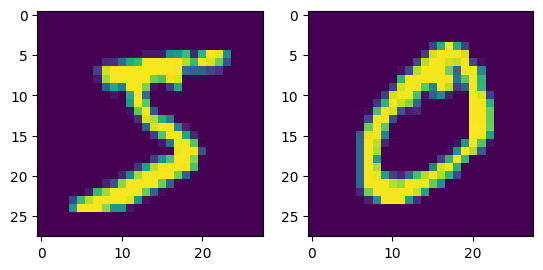

In [3]:
from src.visualization.plotting import image_plotting
image_plotting([mnist_data.train_set.data[0],mnist_data.train_set.data[1]])

To identify a digit, we don't need to consider every pixel in the image. Many pixels, especially those around the edges, contain zero information. When training a linear model for digit recognition, if the model performs well, it implies that it has learned to focus on the informative pixels, typically located in the center of the image.

Our next objective is to leverage this linear model to elucidate how implicit attention is employed. Let's proceed with this exploration.

## Setting up the experiment data

For the sake of demonstration we only take 2 classes of the digits.

In [4]:
from torch.utils.data import DataLoader
from src.models import linear_model, trainer, cnn
from src.data_builder import mnist
import torch
from torch import optim
import matplotlib.pyplot as plt


mnist_data = mnist.MNIST(flatten=True)
subset_data = mnist_data.subset_traindata(labels=[7,9])
train_loader = DataLoader(subset_data, batch_size=64, shuffle=True)

## Modeling a linear (binary) classifier

Now, we'll establish a linear binary classifier using PyTorch:

In [5]:

lm = linear_model.LinearClassifier(dim=28, num_output=2)
optimizer = optim.Adagrad(lm.parameters(), lr=0.01, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
model_trainer = trainer.Trainer(model=lm, optimizer=optimizer,
                  criterion=criterion, train_data=train_loader, num_epoch = 10, vectorized=True)
model_trainer.run(verbose=0)

As mentioned earlier, the weights in a linear model serve as a reflection of how the model implicitly attends to input features. To gain insights into this implicit attention, let's visualize the weights.

**NOTE**: In this particular model, we're dealing with two classes and two output nodes. Consequently, we have two sets of weights, each mapping pixels to one of the output nodes.

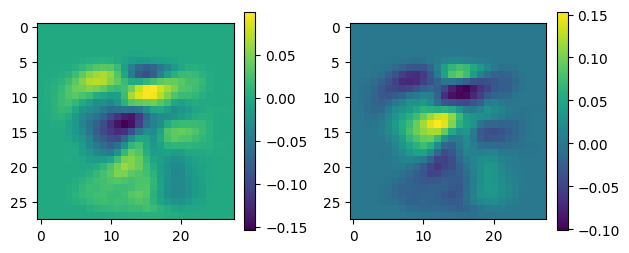

In [7]:
weights = list(lm.get_parameters())[0]
fig, ax = plt.subplots(1,2)
for output in range(0,2):
    im = ax[output].imshow(torch.reshape(weights.data[output],(28,28)))
    _ = fig.colorbar(im,ax=ax[output], fraction=0.05)
plt.tight_layout()


The depicted plots reveal a significant pattern: the learned weights concentrate on extracting information primarily from the center of the images, while the weights for pixels located off the center are nearly equal and close to zero.

This serves as a clear instance of implicit attention in action. No additional design has been imposed on the model to guide its attention; rather, the model implicitly learns to attend effectively, leading to well performance. While our model is relatively simple, it aptly addresses the task at hand. However, it's important to note that for more challenging tasks, a more complex model may be necessary to achieve satisfactory performance.

## Modeling a CNN

Now, let's transition to the entire MNIST dataset, encompassing all 10 classes. Although this task is still moderately challenging, achieving optimal performance may necessitate a more complex model. A straightforward yet effective choice for MNIST is a Convolutional Neural Network (CNN). Here, we'll construct a CNN model: 

In [13]:
# reading data
num_classes= 10
mnist_data = mnist.MNIST(flatten=False)
train_loader = DataLoader(mnist_data.train_set, batch_size=64, shuffle=True)

In [16]:
# model instantiation
cnn_classifier = cnn.CNNClassifier(num_classes)
optimizer = optim.Adagrad(cnn_classifier.parameters(), lr=0.1, weight_decay=1e-10)
criterion = torch.nn.CrossEntropyLoss()


In [15]:
# model training
model_trainer = trainer.Trainer(model=cnn_classifier, optimizer=optimizer,
                  criterion=criterion, train_data=train_loader, num_epoch = 10)
model_trainer.run(verbose=1)

epoch 0 is ended: train loss 0.7746039628982544
epoch 1 is ended: train loss 0.5785013437271118
epoch 2 is ended: train loss 0.49131885170936584
epoch 3 is ended: train loss 0.442940890789032
epoch 4 is ended: train loss 0.4091340899467468
epoch 5 is ended: train loss 0.3839377760887146
epoch 6 is ended: train loss 0.3645370602607727
epoch 7 is ended: train loss 0.3482036888599396
epoch 8 is ended: train loss 0.3352220356464386
epoch 9 is ended: train loss 0.32408028841018677


In the case of logistic regression, we directly examined the weights to gauge the model's attention to relevant inputs. However, for more intricate models like the CNN we previously trained, attention can be conceptualized as the sensitivity of the output concerning changes in the input. This sensitivity is encapsulated by the Jacobian matrix.

For each input-output pair ($x_i, y_j$), the *ij*th element of the Jacobian matrix is represented by:

$$
\frac{\partial y_j}{\partial x_i}
$$

If the model has been effectively trained to prioritize $x_i$ as a crucial feature in predicting $y_j$, the corresponding derivative should be high.

In the case of our simple logistic regression model, it's noteworthy that the weights $W$ serve as an equivalent to the Jacobian matrix.

Thanks to PyTorch, computing the Jacobian matrix becomes a straightforward task.

In [11]:
index=1
image = next(iter(train_loader))[0][[index]] ## choosing an image (arbitrarily)
Jacobian_matrix = torch.autograd.functional.jacobian(cnn_classifier, image).view(10,28,28)


Now, let's visualize the elements of the Jacobian matrix:

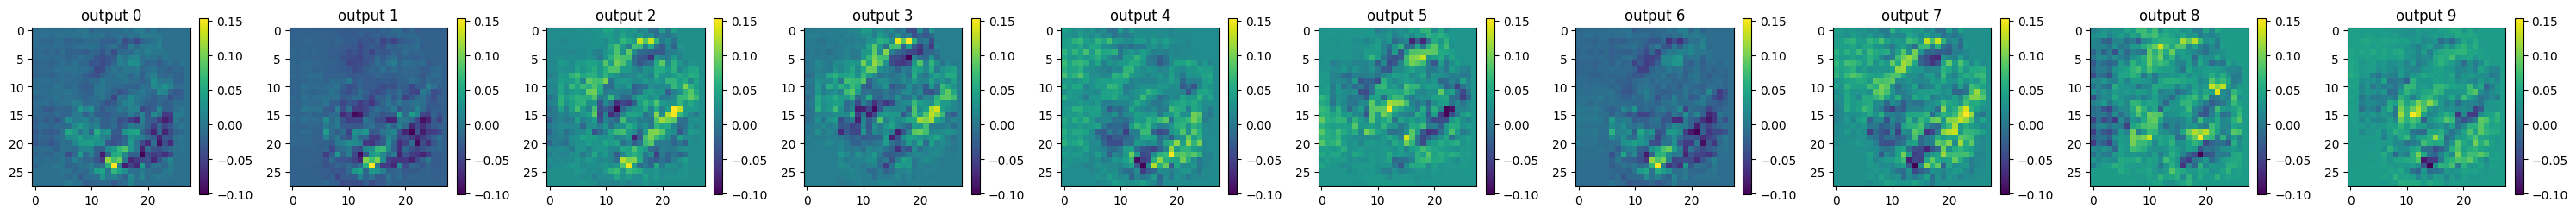

In [12]:
fig, ax = plt.subplots(1,num_classes, figsize=(30,30))
for i in range(num_classes):
    ax[i].imshow(Jacobian_matrix[i])
    ax[i].set_title(f'output {i}')
    _ = fig.colorbar(im,ax=ax[i], fraction=0.05)
plt.tight_layout()

Once more, the visualizations affirm the predominant attention towards the center of the images. It's worth noting that unlike the linear model, the attention pattern varies across inputs (adjust the "index" variable and observe), underscoring the CNN's capacity for more nuanced implicit attention, potentially contributing to enhanced performance.